**Importing necessary libraries for the work flow**

In [182]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# package to read DICOM image
import pydicom 
# package to extract and convert the arrays
from PIL.Image import fromarray 
from PIL import Image
import cv2
from scipy import ndimage
from skimage import measure,color,io
import pandas as pd
import math
plt.style.use(['science', 'notebook', 'grid'])
import seaborn as sns
import matplotlib as mpl
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy.integrate import cumtrapz
from scipy.stats import norm

**Reading DICOM image and saving it in jpg format**

In [183]:
# read dicom image
# https://pydicom.github.io/pydicom/stable/
dataset = pydicom.dcmread('C:/Users/brint/Documents/GitHub/particlesize/28668950')

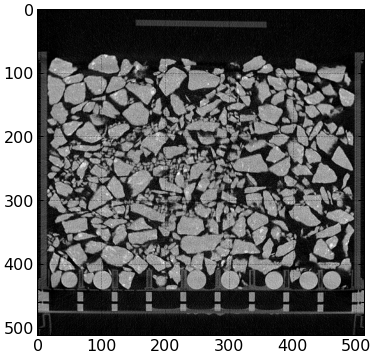

In [184]:
# visualise dicom image in gray scale
plt.imshow(dataset.pixel_array,cmap='gray')
plt.show()

In [185]:
# extract the pixel array as float, to reduce loss of data 
new_image = dataset.pixel_array.astype(float)

In [186]:
# rescale the pixels of the image between 0 to 255 
# normalising then new_image between 0 to 1 and multiplying it by 255 to convert in to gray scale 
scaled_image = (np.maximum(new_image, 0) / new_image.max()) * 255.0

In [187]:
# convert scaled image to 8 bits unsigned integer
scaled_image = np.uint8(scaled_image)
final_image = Image.fromarray(scaled_image)

In [188]:
# save the image as jpg
final_image.save('C:/Users/brint/Documents/GitHub/particlesize/image.jpg')

**Cropping the study area**

In [189]:
# read image for opencv works
img=cv2.imread('C:/Users/brint/Documents/GitHub/particlesize/image.jpg',0)

In [190]:
# get dimensions of image (original)
dim_org = img.shape 
dim_org

(512, 512)

In [191]:
# crop study area 
crop_img=img[70:412,15:498]

In [192]:
dim_crop = crop_img.shape
dim_crop

(342, 483)

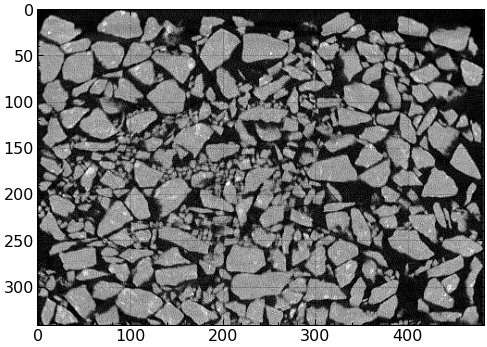

In [193]:
plt.imshow(crop_img,cmap='gray')
plt.show()

**Thresholding**

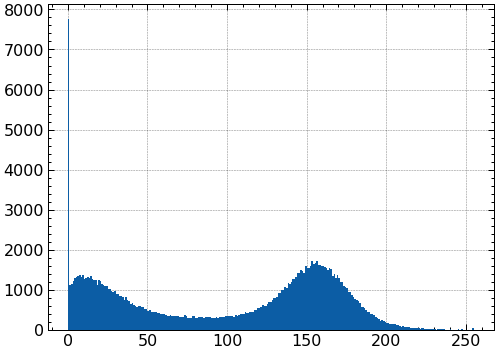

In [194]:
# understanding the manual thresholding value using histogram
Hist=plt.hist(crop_img.flat, bins=255, range=(0,255))
plt.show(Hist)

In [195]:
# read image for opencv works
img=crop_img

In [196]:
# using otsu's algorithm to threshold the image 
# https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
ret, thresh_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret

90.0

In [197]:
cv2.imwrite('C:/Users/brint/Documents/GitHub/particlesize/cropimage.jpg',img)

True

**Application of watershed algorithm**

In [198]:
# noise removal
# https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html
kernel = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(thresh_img,cv2.MORPH_OPEN,kernel, iterations = 1000)

In [199]:
# create sure background 
bg=cv2.dilate(opening,kernel,iterations = 5)

In [200]:
# create sure foreground employing distance transfotmation algorithm
dist_transform = cv2.distanceTransform(opening,cv2.DIST_C,3)

In [201]:
ret2, sure_fg = cv2.threshold(dist_transform,0.13*dist_transform.max(),255,0)

In [202]:
print(dist_transform.max())
sure_fg = np.uint8(sure_fg)

13.0


In [203]:
# find unknown region
unknown = cv2.subtract(bg,sure_fg)

In [204]:
# label the markers
ret3, markers = cv2.connectedComponents(sure_fg)

In [205]:
# Add one to all labels so that sure background is not 0, but 1
markers = markers +1

In [206]:
# mark the region of unknown with zero
markers[unknown==255] = 0

In [207]:
# call back the image in the original colour
img=cv2.imread('C:/Users/brint/Documents/GitHub/particlesize/cropimage.jpg')
# application of watershed algorithm
markers = cv2.watershed(img,markers)

In [208]:
# assign red to the markers with 200 value (i.e., boundary)
img[markers == 200] = [255,0,0]

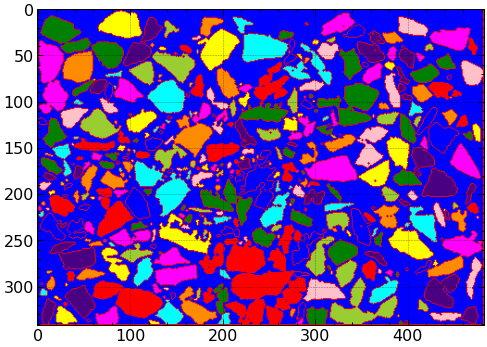

In [209]:
img2 = color.label2rgb(markers, bg_label=0)
plt.imshow(img2)
plt.show()

**Extraction of properties from the segmented image**

In [210]:
# measure the regional properties of labelled segments 
# use intital image with the same size for intensity reference 
# use cache to increase the computational efficiency 
# creating conversion unit from pixel to mm 
px_mm = 1.83
clusters = measure.regionprops(markers,img,cache=True)

In [211]:
# extract the following properties
propList = ['Area',
            'equivalent_diameter', 
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter'
             ] 

In [212]:
# create a csv for properties 
output_file = open('Properties.csv', 'w')
output_file.write(',' + ",".join(propList) + '\n')

68

In [213]:
for cluster_props in clusters:
    output_file.write(str(cluster_props['Label']))
    for i,prop in enumerate(propList):
        if(prop == 'Area'): 
            to_print = cluster_props[prop]*px_mm**2   #Convert pixel square to mm square
        elif(prop == 'equivalent_diameter'): 
            to_print = cluster_props[prop]*px_mm   
        elif(prop == 'MajorAxisLength'): 
            to_print = cluster_props[prop]*px_mm  
        elif(prop == 'MinorAxisLength'): 
            to_print = cluster_props[prop]*px_mm 
        elif(prop == 'Perimeter'): 
            to_print = cluster_props[prop]*px_mm 
        else: 
            to_print = cluster_props[prop]     
        output_file.write(',' + str(to_print))
    output_file.write('\n')
output_file.close()   

In [214]:
prop=pd.read_csv('C:/Users/brint/Documents/GitHub/particlesize/Properties.csv')

In [215]:
# calculation of circularity 
Cir = prop['Area'].mul(4).mul(math.pi).div(prop['Perimeter'].mul(prop['Perimeter'])).to_frame('Circularity')

In [216]:
# merge existing properties with circularity
Mer = pd.concat([prop, Cir], sort=False,axis=1)

In [217]:
# clean the dataset 
Mer = Mer[Mer.Perimeter != 0.0]
Mer = Mer[Mer.Circularity <= 1.0]
Mer = Mer.drop([0,333], axis=0)

In [218]:
Mer.describe()

,Unnamed: 0,Area,equivalent_diameter,MajorAxisLength,MinorAxisLength,Perimeter,Circularity
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,195.139918,959.425396,30.013550,45.788697,23.924541,136.649300,0.624326
std,122.463509,1267.184468,17.946885,27.790605,16.925955,128.589541,0.200567
min,2.000000,40.186800,7.153141,11.390104,3.813624,22.783038,0.078132
25%,83.500000,187.538400,15.452550,24.011843,11.606155,58.062097,0.483586
50%,192.000000,555.917400,26.604812,40.887417,19.851444,107.353200,0.652064
75%,303.500000,1319.466600,40.987470,61.602715,31.616788,173.623362,0.768898
max,403.000000,13362.111000,130.434536,176.940686,140.148420,1465.976954,0.995851


In [219]:
# export cleaned data and call back for the plotting
Mer.to_csv('Final_properties.csv')
Final_work=pd.read_csv('Final_properties.csv')

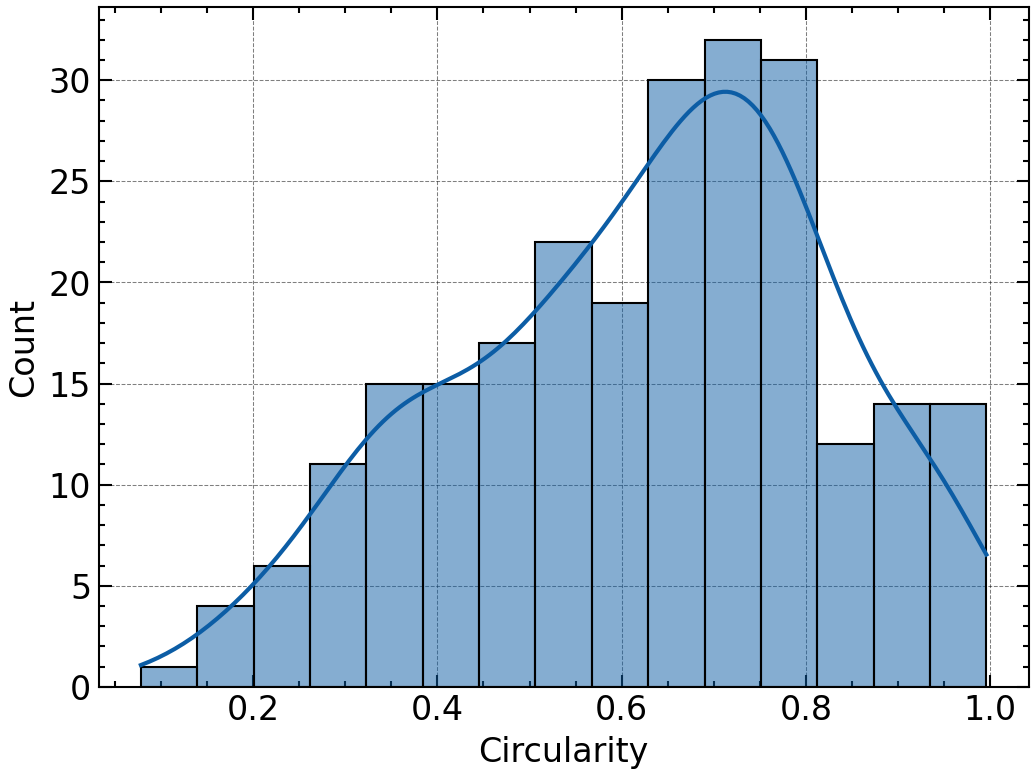

In [220]:
# distribution of circularity 
plt.figure(dpi=150)
circularity=sns.histplot( data=Final_work["Circularity"],bins=15,kde=True,
             line_kws={"linewidth":2,'color': '#b44a46'} )
plt.show(circularity)


B:\Anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


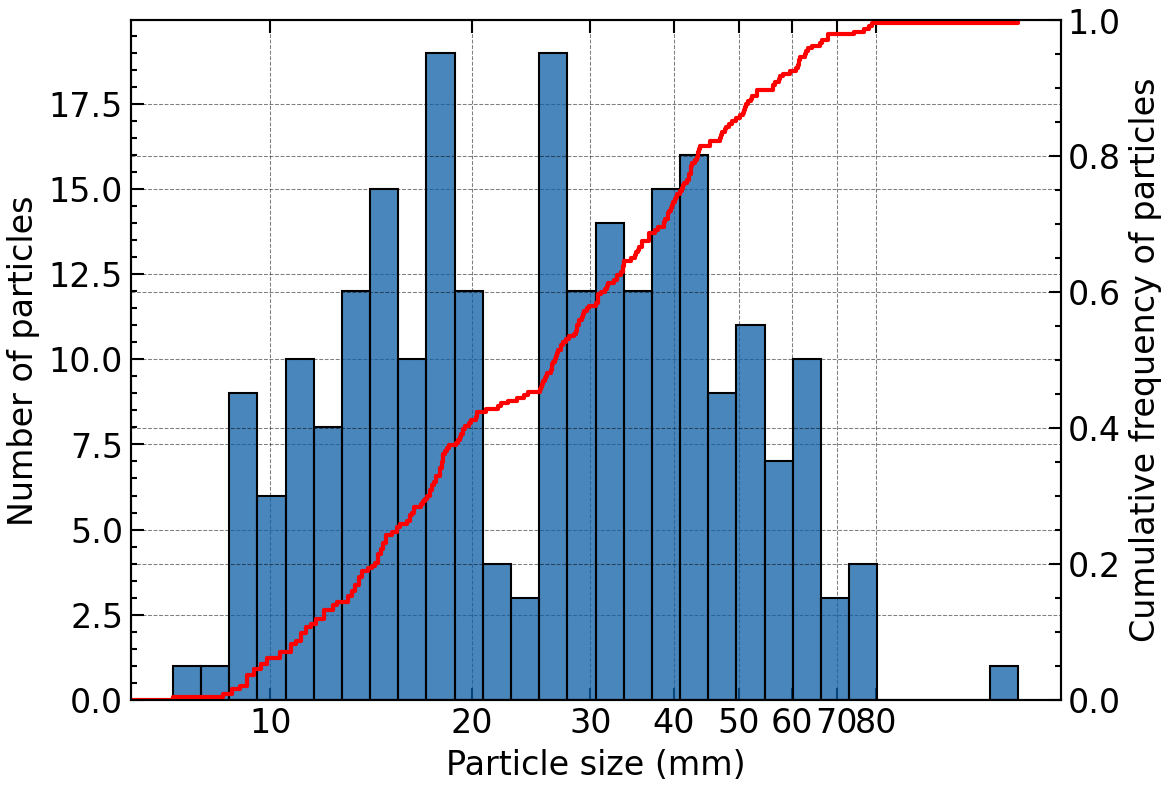

In [221]:
# particle size distribution frequency and cumulative curves
f, ax = plt.subplots(dpi=150)
#sns.despine(f)
ax1=sns.histplot( data=Final_work["equivalent_diameter"],bins=30,kde=False,
             line_kws={"linewidth":2,'color': '#b44a46'},log_scale=True)
ax1 = plt.twinx()
sns.ecdfplot(Final_work,x="equivalent_diameter",ax=ax1,stat="proportion",color='red',
     linewidth=2)

ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([10, 20,30, 40,50,60,70,80])
ax.set(xlabel='Particle size (mm)', ylabel='Number of particles')
ax1.set_ylabel('Cumulative frequency of particles')
plt.show()